# Math 4383 Project
### Zachary Koenig, Colin Crippen

In [91]:
!pip install matplotlib

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [93]:
# --- Load the 8x8 digits dataset ---
digits = load_digits()

# The dataset contains 8x8 images and their corresponding digit labels.
# X contains image data and y contains the target labels.
X = digits.images      # Shape: (n_samples, 8, 8)
y = digits.target      # Shape: (n_samples,)

# --- Data Preprocessing ---

# 1. Flatten the images:
#    Convert each 8x8 image into a 1D array of 64 pixels.
n_samples = X.shape[0]
X_flat = X.reshape(n_samples, -1)   # Now shape is (n_samples, 64)

# 2. Normalize the inputs:
#    The pixel values in the digits dataset are in the range 0-16.
#    Dividing by 16 scales them to the range [0, 1].
X_normalized = X_flat / 16.0

# 3. One-Hot Encode the Labels:
#    There are 10 classes (digits 0-9), so create one-hot encoded vectors.
num_classes = 10
y_onehot = np.eye(num_classes)[y]

# --- Split into Training and Verification (Validation) Sets ---
# For example, reserve 20% of the data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_onehot, test_size=0.2, random_state=42
)

# Verify the shapes
print("Training set shape:", X_train.shape, y_train.shape)  # Should show ~80% of the samples
print("Validation set shape:", X_val.shape, y_val.shape)      # Should show ~20% of the samples
print("One-hot encoded y shape:", y_onehot.shape)    # Expected: (n_samples, 10)

Training set shape: (1437, 64) (1437, 10)
Validation set shape: (360, 64) (360, 10)
One-hot encoded y shape: (1797, 10)


Sigmoid function to enable nonlinear function representation

In [94]:
# --- Activation functions and their derivatives ---

def sigmoid(x):
    """Compute the sigmoid activation."""
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """Compute the derivative of the sigmoid function."""
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    """Compute the softmax activation for each row of x."""
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
    return exps / np.sum(exps, axis=1, keepdims=True)

In [ ]:
# --- Hyperparameters ---
input_size = 8 * 8   # 64 inputs, one per pixel
hidden_size = 64       # You can adjust this
output_size = 10       # 10 classes for digits 0-9

learning_rate = 0.1
epochs = 5_000

# --- Initialize Weights and Biases ---
np.random.seed(89)  # For reproducibility
W1 = np.random.randn(input_size, hidden_size) * 0.01
b1 = np.zeros((1, hidden_size))
W2 = np.random.randn(hidden_size, output_size) * 0.01
b2 = np.zeros((1, output_size))

In [96]:
# --- Training Loop ---
num_train_samples = X_train.shape[0]  # Use real number of training samples
for epoch in range(epochs):
    # Forward pass:
    Z1 = np.dot(X_train, W1) + b1       # Input to hidden layer
    A1 = sigmoid(Z1)                   # Hidden layer activation
    Z2 = np.dot(A1, W2) + b2            # Hidden to output layer
    A2 = sigmoid(Z2)                   # Output activation

    # Compute Cross-Entropy Loss (adding a small constant for numerical stability)
    loss = -np.mean(np.sum(y_train * np.log(A2 + 1e-8), axis=1))
    
       # Backward pass:
    # For softmax and cross-entropy, the gradient simplifies:
    dZ2 = A2 - y_train
    dW2 = np.dot(A1.T, dZ2) / X_train.shape[0]
    db2 = np.sum(dZ2, axis=0, keepdims=True) / X_train.shape[0]
    
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * sigmoid_deriv(Z1)
    dW1 = np.dot(X_train.T, dZ1) / X_train.shape[0]
    db1 = np.sum(dZ1, axis=0, keepdims=True) / X_train.shape[0]
    
    # Update the weights and biases using gradient descent:
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: loss = {loss:.4f}")


# Save the trained weights and biases to disk
np.save('W1.npy', W1)
np.save('b1.npy', b1)
np.save('W2.npy', W2)
np.save('b2.npy', b2)

Epoch 0: loss = 0.6918


Epoch 100: loss = 2.3002
Epoch 200: loss = 2.2971
Epoch 300: loss = 2.2889
Epoch 400: loss = 2.2661
Epoch 500: loss = 2.2046
Epoch 600: loss = 2.0597
Epoch 700: loss = 1.8153
Epoch 800: loss = 1.5567
Epoch 900: loss = 1.3550
Epoch 1000: loss = 1.2054
Epoch 1100: loss = 1.0886
Epoch 1200: loss = 0.9906
Epoch 1300: loss = 0.9037
Epoch 1400: loss = 0.8252
Epoch 1500: loss = 0.7552
Epoch 1600: loss = 0.6936
Epoch 1700: loss = 0.6392
Epoch 1800: loss = 0.5904
Epoch 1900: loss = 0.5463
Epoch 2000: loss = 0.5065
Epoch 2100: loss = 0.4711
Epoch 2200: loss = 0.4400
Epoch 2300: loss = 0.4130
Epoch 2400: loss = 0.3895
Epoch 2500: loss = 0.3691
Epoch 2600: loss = 0.3513
Epoch 2700: loss = 0.3356
Epoch 2800: loss = 0.3216
Epoch 2900: loss = 0.3091


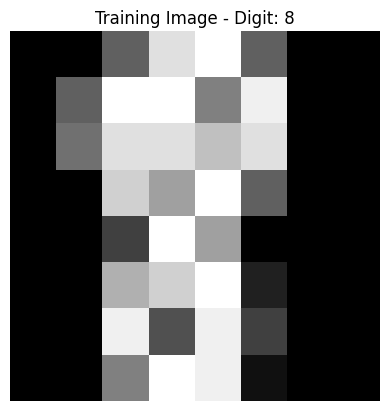

Original shape of x_new: (8, 8)
Flattened shape of x_new: (1, 64)
Predicted digit: 8


In [97]:
# --- Display and Test One Training Image ---
# Select an image from the training set (e.g., first image)
idx = np.random.randint(0, X_val[0].shape)
# Since X_train contains flattened images, reshape it back to 8x8 for display.
img = X_train[idx].reshape(8, 8)
label = np.argmax(y_train[idx])

# Save the image array to a file. Note that the file name comes first.
np.save("test.npy", img)

plt.imshow(img, cmap='gray')
plt.title(f"Training Image - Digit: {label}")
plt.axis('off')
plt.show()

W1 = np.load('W1.npy')
b1 = np.load('b1.npy')
W2 = np.load('W2.npy')
b2 = np.load('b2.npy')

# Load the test image. This image is expected to be an 8x8 array.
x_new = np.load('test.npy')
print("Original shape of x_new:", x_new.shape)  # Should output: (8, 8)

# Flatten the image so that it has shape (1, 64)
x_new = x_new.reshape(1, -1)
print("Flattened shape of x_new:", x_new.shape)  # Should output: (1, 64)

# Perform the forward pass
A1_new = sigmoid(np.dot(x_new, W1) + b1)
A2_new = sigmoid(np.dot(A1_new, W2) + b2)
prediction = np.argmax(A2_new)
print("Predicted digit:", prediction)

In [98]:
# --- Perform Predictions on the Test Set Using the Loaded Weights ---
# Forward pass:
# 1. Compute activations for the hidden layer.
Z1 = np.dot(X_val, W1) + b1   # Linear combination for the hidden layer.
A1 = sigmoid(Z1)              # Apply sigmoid activation.

# 2. Compute activations for the output layer.
Z2 = np.dot(A1, W2) + b2       # Linear combination for the output layer.
A2 = sigmoid(Z2)              # Output activations.

# The predicted class for each sample is the one with the highest activation.
predictions = np.argmax(A2, axis=1)
true_labels = np.argmax(y_val, axis=1)

# Calculate the accuracy of the model on the test set.
accuracy = np.mean(predictions == true_labels)
print("Test set accuracy: {:.2f}%".format(accuracy * 100))

Test set accuracy: 94.72%
